In [291]:
%matplotlib inline
import os
import skimage
from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt
import ntpath
import numpy as np

In [292]:
# Global Variables
DATASET_DIRNAME = "Phos2_0_2MP"
RESCALING_FACTOR = 1. / 5.
NONUNI_KEYWORDS = ["_nonuni_"]
UNI_KEYWORDS = ["_uni_"]

In [293]:
# returns a list of subdirectories under a specific directory
def get_subdirectories(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, subdir_name) for subdir_name in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, subdir_name))]
    else:
        return []

In [294]:
# returns a list of all image files ending with '.png' in that specific directory
def get_files_within_dir(dir_name):
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, file_name) for file_name in os.listdir(dir_name) if file_name.endswith('.png')]
    else:
        return []

In [295]:
# gets a list of images' filenames, rescaling factor, and either the images will be RGB or grayscale
# returns a pair (image's np.ndarray either RGB or grayscale, filename)
def read_images_from_files(filenames, rescale_factor, rgb=True, flatten=False):
    # get a single image's filename to read it
    # returns the rescaled image
    def read_image_from_file(filename):
        img = skimage.io.imread(filename)
        img = rescale(img, rescale_factor, anti_aliasing=True)
        if (flatten==True):
            img = img.flatten()
        if (rgb == True):
            return img
        else:
            return skimage.color.rgb2gray(img)
        
    return [(read_image_from_file(filename), filename) for filename in filenames]

In [296]:
# get dataset directory name, rescaling factor to be applied for all the images and whether the dataset will be RGB or grayscale
# return a list of all images found along with each image filename
def get_all_images(dataset_dirname, rescale_factor, RGB=True):
    subdirectories = get_subdirectories(dataset_dirname)
    all_images = []
    for subdir in subdirectories:
        images_filenames = get_files_within_dir(subdir)
        subdir_images = read_images_from_files(filenames=images_filenames, rescale_factor=rescale_factor, rgb=RGB)
        all_images += subdir_images
    return all_images

In [297]:
def get_images_by_keywords(all_images, keywords):
    
    def keywords_found(filename):
        found = True
        image_filename = ntpath.basename(filename)
        for keyword in keywords:
            found = (found and (keyword in image_filename))
        return found
    
    return [image[0] for image in all_images if keywords_found(image[1]) == True]

In [298]:
images_data = get_all_images(DATASET_DIRNAME, RESCALING_FACTOR, RGB=False)

c:\users\administrator\anaconda3\envs\ottawa\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [299]:
# defining the uniform images and labels
uni_images = get_images_by_keywords(images_data, UNI_KEYWORDS)
uni_labels = np.ones(len(uni_images)).tolist()
# defining the non-uniform images and labels
nonuni_images = get_images_by_keywords(images_data, NONUNI_KEYWORDS)
nonuni_labels = np.zeros(len(nonuni_images)).tolist()

In [300]:
print("Number of examples on uniform illumination pictures is: " + str(len(uni_images)))
print("Number of examples on non-uniform illumination pictures is: " + str(len(nonuni_images)))

Number of examples on uniform illumination pictures is: 135
Number of examples on non-uniform illumination pictures is: 90


In [301]:
def plot_image(image, title=None):
    plt.title(title)
    plt.imshow(image,
               cmap = matplotlib.cm.binary,
               interpolation="nearest")

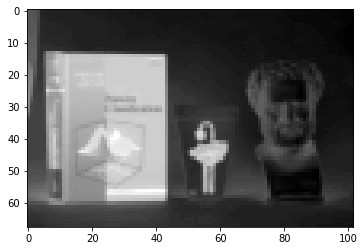

In [302]:
# plotting a random image from the images with uniform illumination
plot_image(uni_images[np.random.randint(low=0, high=len(uni_images)-1)])

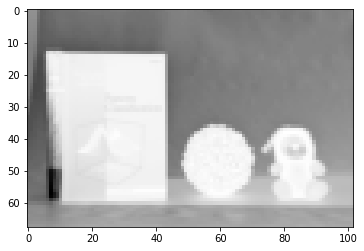

In [303]:
# plotting a random image from the images with non-uniform illumination
plot_image(nonuni_images[np.random.randint(low=0, high=len(nonuni_images)-1)])

In [304]:
X = np.asarray(uni_images + nonuni_images)
y = np.asarray(uni_labels + nonuni_labels)

(68, 102)


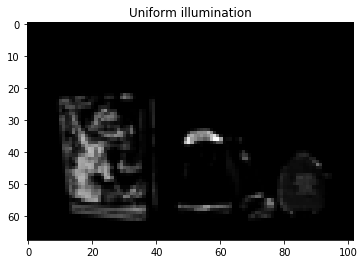

In [305]:
# plotting a random image from the whole dataset and stating its label
random_idx = np.random.randint(low=0, high=len(X)-1)
random_image = X[random_idx]
print(random_image.shape)
image_title = "Uniform illumination" if (y[random_idx] == 1) else "Non-uniform illumination"
plot_image(random_image, title=image_title)

In [306]:
def flatten_images(images):
    return [image.flatten() for image in images]

In [307]:
def shuffle_data(X, y):
    if (len(X) != len(y)):
        return None
    p = np.random.permutation(len(X))
    return X[p], y[p]

In [308]:
flattened_X = np.asarray(flatten_images(X))
print("Shape of X matrix after flatteining all the images is: " + str(flattened_X.shape))

Shape of X matrix after flatteining all the images is: (225, 6936)


In [309]:
shuffled_X, shuffled_y = shuffle_data(flattened_X, y)

In [310]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2, random_state=42)

In [311]:
from sklearn.linear_model import LogisticRegression

bin_clf = LogisticRegression(max_iter=30, tol=0.01, solver='liblinear')
bin_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=30,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.01, verbose=0,
                   warm_start=False)

In [312]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = bin_clf.predict(X_train)
print('Classifier scores on training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_train, y_pred)))
print('Precision is {0} '.format(precision_score(y_train, y_pred)))
print('Recall is {0} '.format(recall_score(y_train, y_pred)))
print('F1 is {0} '.format(f1_score(y_train, y_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_train, y_pred)))

Classifier scores on training set: 
Accuracy is 0.9944444444444445 
Precision is 0.9904761904761905 
Recall is 1.0 
F1 is 0.9952153110047847 
And the confusion matrix: 
 [[ 75   1]
 [  0 104]]


In [313]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = bin_clf.predict(X_test)
print('Classifier scores on training set: ')
print('Accuracy is {0} '.format(accuracy_score(y_test, y_pred)))
print('Precision is {0} '.format(precision_score(y_test, y_pred)))
print('Recall is {0} '.format(recall_score(y_test, y_pred)))
print('F1 is {0} '.format(f1_score(y_test, y_pred)))
print('And the confusion matrix: \n {0}'.format(confusion_matrix(y_test, y_pred)))

Classifier scores on training set: 
Accuracy is 0.9555555555555556 
Precision is 0.9393939393939394 
Recall is 1.0 
F1 is 0.96875 
And the confusion matrix: 
 [[12  2]
 [ 0 31]]
